# 2021/12/22
# 本代码绘制论文version1.0中的图7
# 模式的降水hov图和风向角转变图

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr
import sys

sys.path.append("/home/sun/mycode/module/")
from module_sun import *

In [2]:
time_slice  =  slice(100,201)
lat_slice   =  slice(10,25)
lon_slice   =  slice(55,145)

# 模式实验结果
path            =  "/home/sun/qomo-data/zhuang_plev/"
f               =  xr.open_dataset(path+"famil_zhuang_con_prect.nc")

control_prect   =  xr.open_dataset(path+"famil_zhuang_con_prect.nc").sel(time=time_slice,lat = lat_slice,lon = lon_slice)
noic_prect      =  xr.open_dataset(path+"famil_zhuang_ic_prect.nc").sel(time=time_slice,lat = lat_slice,lon = lon_slice)
noid_prect      =  xr.open_dataset(path+"famil_zhuang_id_prect.nc").sel(time=time_slice,lat = lat_slice,lon = lon_slice)
noicid_prect    =  xr.open_dataset(path+"famil_zhuang_icid_prect.nc").sel(time=time_slice,lat = lat_slice,lon = lon_slice)

np.set_printoptions(suppress=True)
#Compute weights and take weighted average over latitude dimension
weights      =  np.cos(np.deg2rad(noic_prect.lat.values))

avg_control  =  (control_prect.prect*weights[None, :, None]).sum(dim='lat')/np.sum(weights)
avg_noic     =  (noic_prect.prect*weights[None, :, None]).sum(dim='lat')/np.sum(weights)
avg_noid     =  (noid_prect.prect*weights[None, :, None]).sum(dim='lat')/np.sum(weights)
avg_noicid   =  (noicid_prect.prect*weights[None, :, None]).sum(dim='lat')/np.sum(weights)

# 观测结果
lat_slice   =  slice(10,25)
cesm_prect   =  xr.open_dataset("/home/sun/data/cesm_control_prect_365_climate.nc")
merra2_prect =  xr.open_dataset("/home/sun/data/merra2_prect_365_climate.nc")
gpcp_prect   =  xr.open_dataset("/home/sun/data/gpcp_prect_365_climate.nc")
trmm_prect   =  xr.open_dataset("/home/sun/data/trmm_prect_365_climate.nc")
prect1      =  cesm_prect["prect"].sel(time=time_slice,
                                       lat = lat_slice,
                                       lon = lon_slice)
prect2      =  merra2_prect["prect"].sel(time=time_slice,
                                       lat = lat_slice,
                                       lon = lon_slice)
prect3      =  gpcp_prect["prect"].sel(time=time_slice,
                                       lat = lat_slice,
                                       lon = lon_slice)
prect4      =  trmm_prect["prect"].sel(time=time_slice,
                                       lat = lat_slice,
                                       lon = lon_slice)

np.set_printoptions(suppress=True)
#Compute weights and take weighted average over latitude dimension
weights1  =  np.cos(np.deg2rad(prect1.lat.values))
weights2  =  np.cos(np.deg2rad(prect2.lat.values))
weights3  =  np.cos(np.deg2rad(prect3.lat.values))
weights4  =  np.cos(np.deg2rad(prect4.lat.values))
avg_prect1  =  (prect1*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1)
avg_prect2  =  (prect2*weights2[None, :, None]).sum(dim='lat')/np.sum(weights2)
avg_prect3  =  (prect3*weights3[None, :, None]).sum(dim='lat')/np.sum(weights3)
avg_prect4  =  (prect4*weights4[None, None, :]).sum(dim='lat')/np.sum(weights4)

# 单张

In [3]:
# 坐标轴设置
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('Blues', 16)
newcolors = viridis(np.linspace(0, 1, 16))
newcmp = ListedColormap(newcolors)
newcmp.set_under('white')
newcmp.set_over('darkblue')

#levels
clevs = np.arange(5,28,2)

# Tick labels
x_tick_labels = []
for xx in range(60,141,10):
    x_tick_labels.append(u''+str(xx)+"\N{DEGREE SIGN}E")

y_tick = [100,110,120,130,140,150,161,171,181,191,201]
y_label = ['10Apr','20Apr','30Apr','10May','20May','30May','10Jun','20Jun','30Jun','10Jul','20Jul']

# Fig7

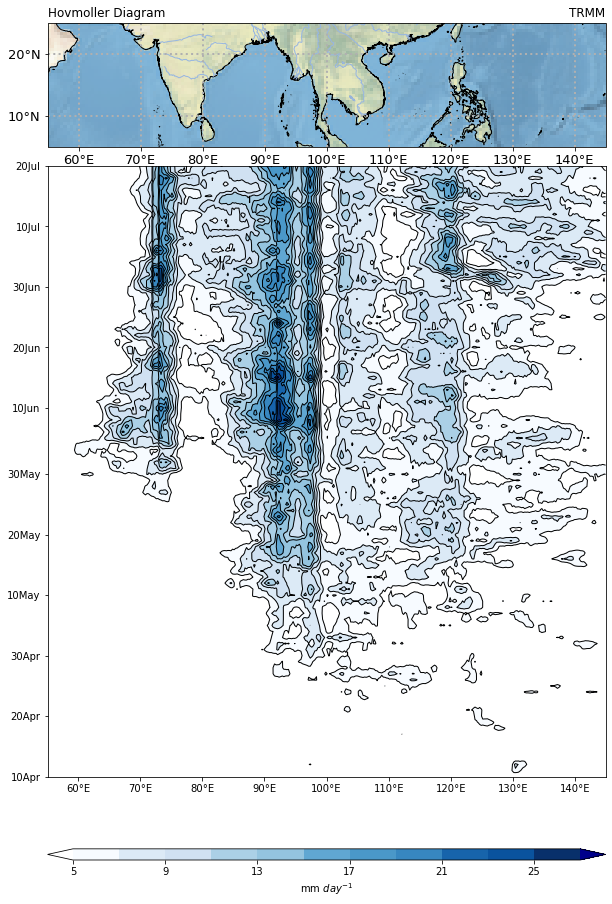

In [4]:
# Start figure
fig = plt.figure(figsize=(10, 17.5))
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)


# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([55, 145, 5, 25], ccrs.PlateCarree())
ax1.set_yticks([10, 20])
ax1.set_yticklabels([u'10\N{DEGREE SIGN}N', u'20\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(60,141,10))
ax1.set_xticklabels(x_tick_labels)
ax1.tick_params(labelsize=13)
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.05)
ax1.add_feature(cfeature.RIVERS)
ax1.add_feature(cfeature.LAKES)
ax1.stock_img()

# Set some titles
plt.title('Hovmoller Diagram', loc='left')
plt.title('TRMM', loc='right')

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
#ax2.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
cf   = ax2.contourf(prect4.lon.values, prect4.time.values, 1.0*avg_prect4, clevs, cmap=newcmp, extend='both')
cs   = ax2.contour(prect4.lon.values,  prect4.time.values, 1.0*avg_prect4, clevs, colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.09, aspect=50)
cbar.set_label('mm $day^{-1}$')

ax2.set_xticks(np.arange(60,141,10))
ax2.set_xticklabels(x_tick_labels)
ax2.tick_params(labelsize=10)

ax2.set_yticks(y_tick)
ax2.set_yticklabels(y_label)

plt.savefig("/home/sun/paint/lunwen/version1.0/fig7_version1.0_trmm_hov.pdf",dpi=300)
plt.show()

# 多张——模式结果

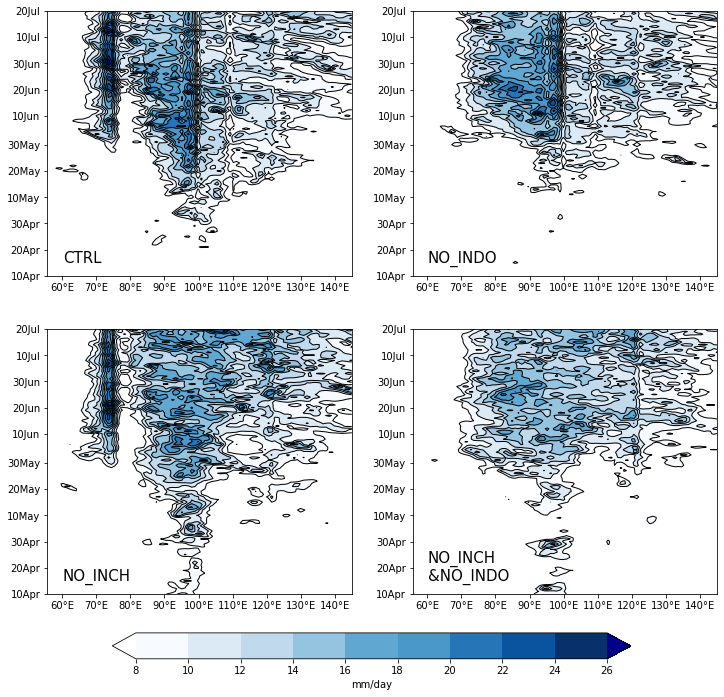

In [27]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


props = dict(boxstyle='square', edgecolor='white', facecolor='white', alpha=1)

proj    =  ccrs.PlateCarree()
fig1    =  plt.figure(figsize=(12,12))
spec1   =  fig1.add_gridspec(nrows=2,ncols=2)


j = 0
prect  =  [avg_control,avg_noic,avg_noid,avg_noicid]
name   =  ["CTRL","NO_INCH","NO_INDO","NO_INCH\n&NO_INDO"]
    
for col in range(2):
    for row in range(2):
            ax = fig1.add_subplot(spec1[row,col])
            # 设置经纬度刻度.
            if j == 2 or j == 3:
                cf   = ax.contourf(control_prect.lon.values, control_prect.time.values,prect[j]*0.95, clevs, cmap=newcmp, extend='both')
                cs   = ax.contour(control_prect.lon.values,  control_prect.time.values,prect[j]*0.95, clevs, colors='k', linewidths=1)
            else:
                cf   = ax.contourf(control_prect.lon.values, control_prect.time.values,prect[j]*1.05, clevs, cmap=newcmp, extend='both')
                cs   = ax.contour(control_prect.lon.values,  control_prect.time.values,prect[j]*1.05, clevs, colors='k', linewidths=1)
            ax.text(0.05,0.05,name[j],transform=ax.transAxes,bbox=props,fontsize=15)
        
            j += 1
            ax.set_xticks(np.arange(60,141,10))
            ax.set_xticklabels(x_tick_labels)
            ax.tick_params(labelsize=10)

            ax.set_yticks(y_tick)
            ax.set_yticklabels(y_label)


fig1.subplots_adjust(top=0.8) 
cbar_ax = fig1.add_axes([0.2, 0.05, 0.6, 0.03]) 
fig1.colorbar(cf, cax=cbar_ax, shrink=0.1, pad=0.01, orientation='horizontal',label='mm/day')


plt.savefig("/home/sun/paint/lunwen/version1.0/fig7_version1.0_model_prect_hov.pdf", bbox_inches='tight', dpi=300)
plt.show()